In [34]:
from continuous_simulations import spread_continuous_rumour
from networkx.classes.graph import Graph
import networkx as nx
import numpy as np
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from display_simulations import display_simulation

from matplotlib import rc
rc('animation', html='jshtml')
%matplotlib inline

In [ ]:
c = 1.5
c_0 = 1/2 + 1/np.exp(1)
C = (10*c + 20)/c_0

In [ ]:
DEFAULT_MAX_NODES = 300
x = np.linspace(1, DEFAULT_MAX_NODES, 2*DEFAULT_MAX_NODES)

In [ ]:
def spreading_scaling_simulation(graph_generator, min_nodes = 10, max_nodes = DEFAULT_MAX_NODES, step = 10, runs_per_size = 10):
    results = []
    means = []
    for n in range(min_nodes, max_nodes+1, step):
        spreading_times = [spread_continuous_rumour(graph_generator, n) for i in range(runs_per_size)]
        # results.append((n, np.median(spreading_times)))
        spreading_time_tuples = [(n, spreading_time) for spreading_time in spreading_times]
        results.extend(spreading_time_tuples)
        means.append((n, np.mean(spreading_times)))
    return results, means

### Ring Graph

In [ ]:
def ring_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    return nx.cycle_graph(number_of_nodes)

results, means = spreading_scaling_simulation(ring_generator, runs_per_size=10, max_nodes=300)

plt.figure(dpi=400)
plt.scatter(*zip(*results))
plt.scatter(*zip(*means), c='r')
plt.xlabel("Number of nodes")
plt.ylabel("Spreading Time")
f = C * x * np.log(x) / 2
plt.plot(x, f, 'g')
plt.show()

### Shuffled Ring Graph

In [ ]:
def shuffled_ring_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    node_permutation = np.random.permutation(number_of_nodes)
    return nx.cycle_graph(node_permutation)

results, means = spreading_scaling_simulation(shuffled_ring_generator, runs_per_size=30, max_nodes=500)

plt.figure(dpi=400)
plt.scatter(*zip(*results))
plt.scatter(*zip(*means), c='r')
plt.xlabel("Number of nodes")
plt.ylabel("Spreading Time")
# f = C * x * np.log(x) / 2
# plt.plot(x, f, 'g')
plt.show()

### Complete Graph

In [ ]:
def complete_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    return nx.complete_graph(number_of_nodes)

results, means = spreading_scaling_simulation(complete_generator)

plt.scatter(*zip(*results))
plt.scatter(*zip(*means), c='r')
f = 2 * C * np.log(x)
plt.plot(x, f, 'g')
plt.show()

### ER Random Graph

In [ ]:
def ER_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    p = 1/np.log(number_of_nodes) # TODO: Check if this works - log log scaling gives same result? seems too fast
    return nx.fast_gnp_random_graph(number_of_nodes, p)

results, means = spreading_scaling_simulation(ER_generator)

plt.scatter(*zip(*results))
plt.scatter(*zip(*means), c='r')
plt.show()

### Static Star Graph (Initial node not hub)

In [ ]:
def static_star_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    # Generates list [1,2, ..., number_of_nodes - 1, 0]
    # First node in list is hub
    nodes = [(i+1) % number_of_nodes for i in range(number_of_nodes)]

    return nx.star_graph(nodes)

results, means = spreading_scaling_simulation(static_star_generator)

plt.scatter(*zip(*results))
plt.scatter(*zip(*means), c='r')
f = C * np.log(x)
plt.plot(x, f, 'r')
plt.show()

### Adversarial Star Graph 

In [ ]:
def adversarial_star_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    uninformed_nodes = [v for v in range(number_of_nodes) if not (v in informed_nodes)]
    if len(informed_nodes) <= number_of_nodes / 2:
        node_set = uninformed_nodes + list(informed_nodes)
    else:
        node_set = list(informed_nodes) + uninformed_nodes
    return nx.star_graph(node_set)

results, means = spreading_scaling_simulation(adversarial_star_generator)

plt.scatter(*zip(*results))
plt.scatter(*zip(*means), c='r')
f = C * np.log(x)
plt.plot(x, f, 'r')
plt.show()

In [ ]:
events = spread_continuous_rumour(adversarial_star_generator, 10, enable_event_log=True)
# display_simulation(events)

TODO: Is adverasial graph generator working properly?

### Shuffled Star Graph

In [ ]:
def shuffled_star_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    node_permutation = np.random.permutation(number_of_nodes)
    return nx.star_graph(node_permutation)

results, means = spreading_scaling_simulation(shuffled_star_generator)

plt.scatter(*zip(*results))
plt.scatter(*zip(*means), c='r')
plt.show()

### Complete Graph String

In [ ]:
SUBGRAPH_SIZE = 10
def complete_string_generator(number_of_nodes, timestep, informed_nodes):
    number_of_subgraphs = int(number_of_nodes / SUBGRAPH_SIZE)
    complete_graphs = [nx.complete_graph(SUBGRAPH_SIZE) for i in range(number_of_subgraphs)]
    g = nx.disjoint_union_all(complete_graphs)
    for i in range(number_of_subgraphs - 1):
        g.add_edge(i * SUBGRAPH_SIZE, (i+1)*SUBGRAPH_SIZE + SUBGRAPH_SIZE - 1)
    return g

results, means = spreading_scaling_simulation(complete_string_generator, step=50)

plt.scatter(*zip(*results))
plt.scatter(*zip(*means), c='r')
plt.show()

## Figures

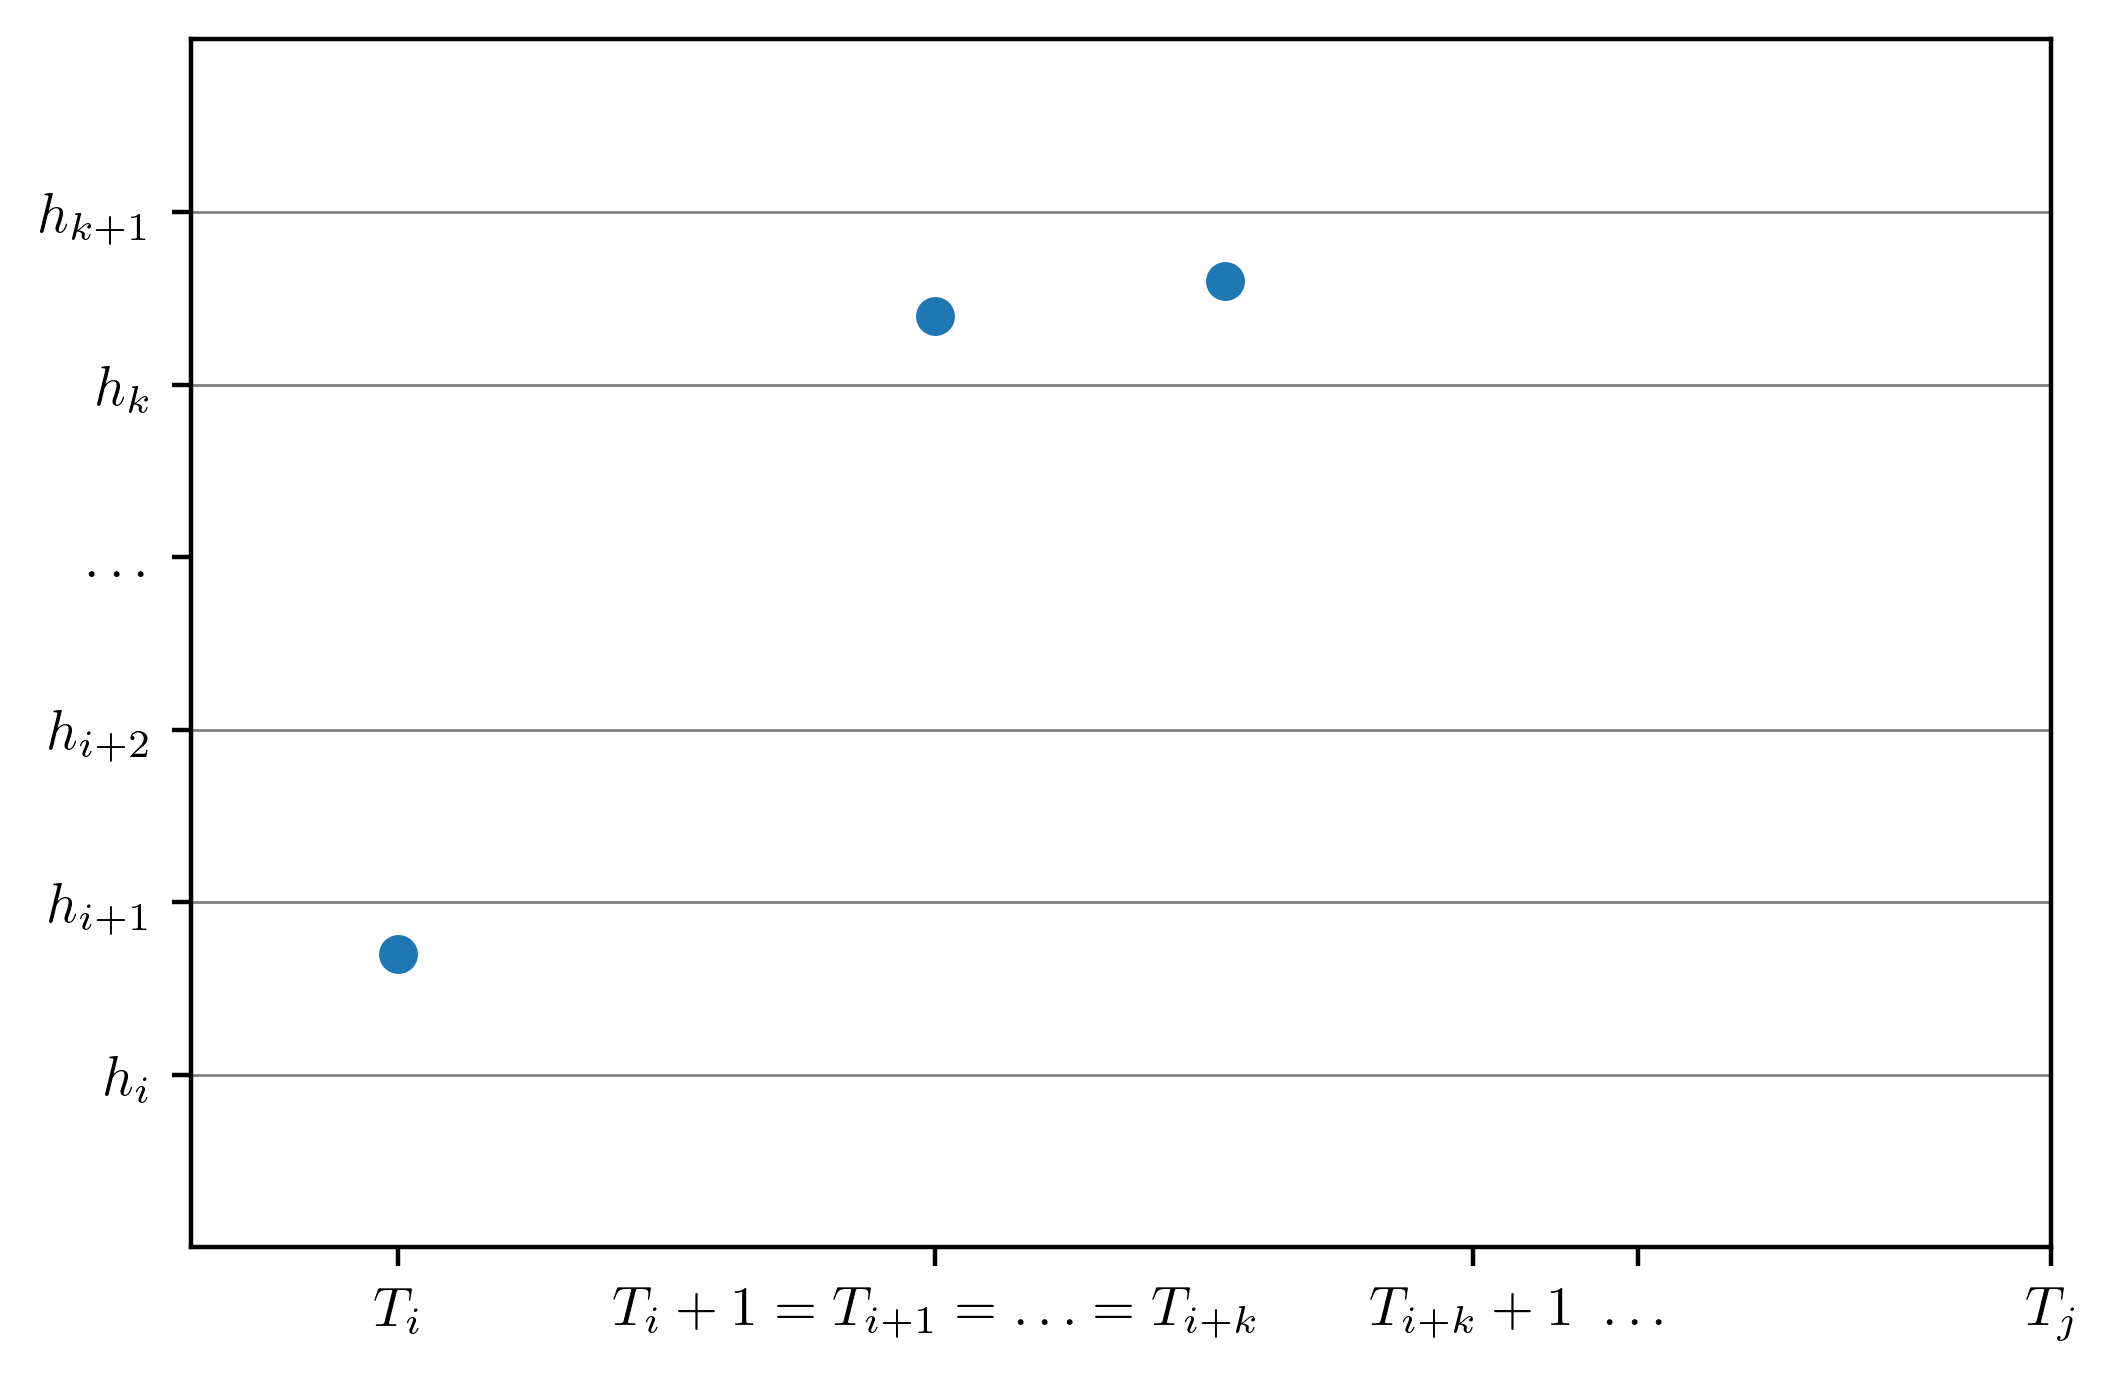

In [79]:
rc('text', usetex='True')
fig, ax = plt.subplots()
fig.set_dpi(400)
ax.scatter([1,2.3,3],[1.7,5.4, 5.6])
ax.xaxis.set_ticks([1,2,3,4])
xlabels = ["$T_i$","$T_i + 1 = T_{i+1} = \dots = T_{i+k}$", "$T_{i+k} + 1$", "$\dots$", "$T_j$"]
ax.xaxis.set_ticks([1,2.3,3.6,4,5])
ax.set_xticklabels(xlabels)

ax.set_xlim(0.5,5)
ax.set_ylim(0,7)

ylabels = ["$h_i$", "$h_{i+1}$", "$h_{i+2}$", "$\dots$", "$h_k$", "$h_{k+1}$"]
ax.yaxis.set_ticks(list(range(1, len(ylabels) + 1)))
ax.set_yticklabels(ylabels)

for i in [1,2,3,5,6]:
    ax.axhline(i, color='grey', linewidth=0.5)
plt.show()